In [1]:
!pip install transformers --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_df = pd.read_csv('../input/shopee-sentiment-analysis/train.csv')
test_df = pd.read_csv('../input/shopee-sentiment-analysis/test.csv')

train_df.shape, test_df.shape

((146811, 3), (60427, 2))

In [4]:
train_df.head()

review_id                                             review  rating
0          0  Ga disappointed neat products .. Meletot Hilsn...       1
1          1    Rdtanya replace broken glass, broken chargernya       1
2          2  Nyesel bngt dsni shopping antecedent photo mes...       1
3          3      Sent a light blue suit goods ga want a refund       1
4          4  Pendants came with dents and scratches on its ...       1

In [5]:
test_df.head()

review_id                                             review
0          1  Great danger, cool, motif and cantik2 jg model...
1          2                   One of the shades don't fit well
2          3                                   Very comfortable
3          4  Fast delivery. Product expiry is on Dec 2022. ...
4          5  it's sooooo cute! i like playing with the glit...

In [6]:
duplicated_df = train_df[train_df.review.duplicated()]
print("Number of duplicated reviews : ", duplicated_df.shape[0])

Number of duplicated reviews :  31483


In [7]:
duplicated_2_df = duplicated_df[duplicated_df.rating.duplicated() & duplicated_df.review.duplicated()]
print("Number of duplicated reviews with same rating: ", duplicated_2_df.shape[0])

Number of duplicated reviews with same rating:  29376


In [8]:
train_df.drop_duplicates(subset='review', inplace=True)
train_df.reset_index(drop=True, inplace=True)

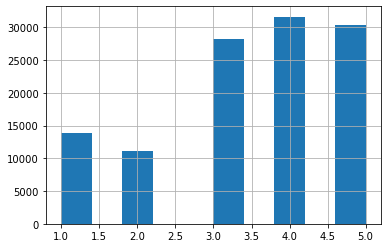

In [9]:
train_df.rating.hist();

# Data Collection

We obtain some additonal dataset from other account. We will merge them with training set.

In [10]:
# kaggle.com/liuhh02/test-labelled
# old test leak labelled
test_labelled = pd.read_csv('../input/shopeesentimentadditional/test_labelled.csv')
test_labelled

review_id                                             review  rating
0              0                                      slow delivery       1
1              1               Dateng goods do not conform pesanan😔       1
2              2                             PSN k its 20 other DTG       1
3              3  I am expected that it have a frame and painted...       1
4              4                   The product quality is not good.       1
...          ...                                                ...     ...
62913      62913  Has shipped It was the model that fits the cut...       5
62914      62914       Awesome awesome speed of the ship's value CP       5
62915      62915  but already in lebihin one of its usual size w...       5
62916      62916                  The product quality is excellent.       5
62917      62917  Excellent product quality, original product, t...       5

[62918 rows x 3 columns]

In [11]:
dup_testlab = test_labelled[test_labelled['review'].duplicated()]
print(f'Number of duplicated reviews: {dup_testlab.shape[0]}')
dup_testlab['check'] = dup_testlab.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_testlab['check'].duplicated().sum(),'of duplicate reviews have the same rating')

Number of duplicated reviews: 13040
11667 of duplicate reviews have the same rating


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
test_labelled.drop_duplicates(subset = 'review', inplace = True)

In [13]:
# kaggle.com/shymammoth/shopee-reviews
# scraped shopee reviews
scraped_reviews = pd.read_csv('../input/shopeesentimentadditional/shopee_reviews.csv')
scraped_reviews

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


label                                               text
0           5  Looks ok. Not like so durable. Will hv to use ...
1           5  Tried, the current can be very powerful depend...
2           5  Item received after a week. Looks smaller than...
3           5  Thanks!!! Works as describe no complaints. Not...
4           5  Fast delivery considering it’s from overseas a...
...       ...                                                ...
1502570     5  Tried and it fit nicely will buy \nFast and go...
1502571     5  It's a fantastic product. Very reasonable pric...
1502572     5  Nice pair of shoes for a gd price. Note the cu...
1502573     1  Leather?   Rubbish....moulded plastic. What a ...
1502574     3  Your size 41 smaller than normal, more like si...

[1502575 rows x 2 columns]

In [14]:
scraped_reviews.rename(columns = {'text': 'review', 'label': 'rating'}, inplace = True)

In [15]:
scraped_reviews['rating'].value_counts()

5        1137695
5         166237
4          88686
3          42911
1          24704
2          16724
4          13443
3           6172
1           3650
2           2352
label          1
Name: rating, dtype: int64

In [16]:
scraped_reviews = scraped_reviews[scraped_reviews['rating'] != 'label']
scraped_reviews['rating'] = scraped_reviews['rating'].astype(int)
scraped_reviews['rating'].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


5    1303932
4     102129
3      49083
1      28354
2      19076
Name: rating, dtype: int64

In [17]:
dup_scraped = scraped_reviews[scraped_reviews['review'].duplicated()]
print(f'No. of duplicate reviews: {dup_scraped.shape[0]}')

No. of duplicate reviews: 0


In [18]:
train_df = train_df.append(test_labelled, ignore_index = True)
train_df = train_df.append(scraped_reviews, ignore_index = True)
train_df = train_df.sample(frac = 1).reset_index(drop = True)

# Data Preprocessing

### Remove duplicates

In [19]:
dup_train = train_df[train_df['review'].duplicated()]
print(f'No. of duplicate reviews on train data: {dup_train.shape[0]}')
dup_train['check'] = dup_train.apply(lambda x: str(x.review) + str(x.rating), axis = 1)
print(dup_train['check'].duplicated().sum(),'of duplicate reviews have the same rating')

No. of duplicate reviews on train data: 33166
198 of duplicate reviews have the same rating


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
train_df

review_id                                             review  rating
0              NaN  Product came pretty quickly, and is quite stur...       5
1          44775.0  unexpected too huhu to the wire coat. but the ...       4
2              NaN       Materials seem thinner than picture shown.\n       3
3              NaN  Very mini size. I have been using Laneige lip ...       5
4              NaN  Very happy with this buy! Can treat as a forma...       5
...            ...                                                ...     ...
1667775        NaN  Have received the item in good condition,thank...       5
1667776    18111.0  Her size 2 bgt same rich will ngepas my mouth ...       3
1667777        NaN             Good quality.. Silky material. Love it       5
1667778        NaN  Looks good and delivery take about 10 days. No...       5
1667779        NaN  This is my second order.  Really like the prod...       5

[1667780 rows x 3 columns]

In [21]:
train_df['rating'].value_counts()

5    1347428
4     147498
3      89644
1      48145
2      35065
Name: rating, dtype: int64

In [22]:
# Trim train set by half to minimize training time
train_df = train_df.drop(train_df[train_df['rating'] == 5].sample(frac = .6).index)
print(train_df['rating'].value_counts())
print(train_df.shape)

5    538971
4    147498
3     89644
1     48145
2     35065
Name: rating, dtype: int64
(859323, 3)


In [23]:
train_df.reset_index(drop=True, inplace=True)

### Cleaning emoji

In [24]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer, WordNetLemmatizer

stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

from string import punctuation
import emoji 
import re

In [25]:
def emoji_cleaning(text):
    
    # change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [26]:
train_emoji_ids = []
test_emoji_ids = []

for idx, review in enumerate(train_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        train_emoji_ids.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        test_emoji_ids.append(idx)

In [27]:
train_df.loc[train_emoji_ids, 'review'] = train_df.loc[train_emoji_ids, 'review'].apply(emoji_cleaning)
test_df.loc[test_emoji_ids, 'review'] = test_df.loc[test_emoji_ids, 'review'].apply(emoji_cleaning)

In [28]:
def emoticon_cleaning(text):
    
    text = text.lower()
    # remove new line
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [29]:
train_df['review'] = train_df['review'].apply(emoticon_cleaning)
test_df['review'] = test_df['review'].apply(emoticon_cleaning)

In [30]:
train_repeteadedchar_ids = []
test_repeteadedchar_ids = []

for idx, review in enumerate(train_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        train_repeteadedchar_ids.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        test_repeteadedchar_ids.append(idx)

In [31]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [32]:
train_df.loc[train_repeteadedchar_ids, 'review'] = train_df.loc[train_repeteadedchar_ids, 'review'].apply(delete_repeated_char)
test_df.loc[test_repeteadedchar_ids, 'review'] = test_df.loc[test_repeteadedchar_ids, 'review'].apply(delete_repeated_char)

In [33]:
def recover_shortened_words(text):
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [34]:
train_df['review'] = train_df['review'].apply(recover_shortened_words)
test_df['review'] = test_df['review'].apply(recover_shortened_words)

In [35]:
def clean_review(text):
    
    review = str(text)
    # only keep alphabet
    review = re.sub('[^a-zA-Z]', ' ', review)
    # lemmatization
    review = [lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
    review = ' '.join(review)
    
    return review

In [36]:
train_df['review'] = train_df['review'].apply(clean_review)
test_df['review'] = test_df['review'].apply(clean_review)

In [37]:
# def count_len(text):
#     return len(word_tokenize(text))

# train_len = train_df['review'].apply(count_len)
# test_len = test_df['review'].apply(count_len)

In [38]:
# train_len.hist();

In [39]:
# test_len.hist();

In [40]:
# print(np.max(train_len), np.max(test_len))

# Modeling

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

import tensorflow_addons as tfa

print('Using Tensorflow version:', tf.__version__)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Using Tensorflow version: 2.2.0


In [42]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [43]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MODEL = 'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased

In [44]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_attention_masks=False, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])


In [45]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    hidden_layer_1 = Dense(int(max_len/2), activation='relu')(cls_token)
    hidden_layer_1 = tf.keras.layers.Dropout(.2)(hidden_layer_1)
    hidden_layer_2 = Dense(int(max_len/4), activation='relu')(hidden_layer_1)
    hidden_layer_2 = tf.keras.layers.Dropout(.2)(hidden_layer_2)
    
    out = Dense(5, activation='softmax')(hidden_layer_2) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-5,weight_decay=1e-6)
    
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [46]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [47]:
MAX_LEN = 104

In [48]:
train_df['rating'] = train_df['rating'] - 1

In [49]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train_df['rating'], num_classes=5)

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.1,
                                                  random_state=1111)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((773390,), (85933,), (773390, 5), (85933, 5))

In [51]:
X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_val = regular_encode(X_val.values, tokenizer, maxlen=MAX_LEN)
X_test = regular_encode(test_df['review'].values, tokenizer, maxlen=MAX_LEN)

In [52]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

In [53]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 104)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 104, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 52)                53300     
_________________________________________________________________
dropout_74 (Dropout)         (None, 52)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                1378      
_________________________________________________________________
dropout_75 (Dropout)         (None, 26)                0    

In [54]:
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/4


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


6042/6042 [==============================] - 1847s 306ms/step - loss: 0.8751 - accuracy: 0.6792 - val_loss: 0.6989 - val_accuracy: 0.7354
Epoch 2/4
6042/6042 [==============================] - 1810s 300ms/step - loss: 0.7354 - accuracy: 0.7201 - val_loss: 0.6708 - val_accuracy: 0.7406
Epoch 3/4
6042/6042 [==============================] - 1817s 301ms/step - loss: 0.6975 - accuracy: 0.7325 - val_loss: 0.6623 - val_accuracy: 0.7429
Epoch 4/4
6042/6042 [==============================] - 1825s 302ms/step - loss: 0.6673 - accuracy: 0.7428 - val_loss: 0.6505 - val_accuracy: 0.7432


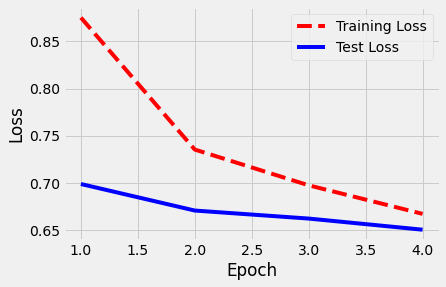

In [55]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [56]:
pred = model.predict(test_dataset, verbose=1)

473/473 [==============================] - 41s 87ms/step


In [57]:
# for ensemble
np.save('xlm-roberta', pred)

In [58]:
pred_sentiment = np.argmax(pred, axis=1)

In [59]:
submission = pd.DataFrame({'review_id': test_df['review_id'],
                           'rating': pred_sentiment})

In [60]:
submission['rating'] = submission['rating'] + 1
submission.to_csv('submission.csv', index=False)
submission['rating'].value_counts()

5    23175
4    22864
3     9672
1     3282
2     1434
Name: rating, dtype: int64